# Autoencoders in SciKeras

Autencoders are an approach to use nearual networks to distill data into it's most important features, thereby compressing the data. We will be following the [Keras tutorial](https://blog.keras.io/building-autoencoders-in-keras.html) on the topic, which goes much more in depth and breadth than we will here. You are highly encouraged to check out that tutorial if you want to learn about autoencoders in the general sense.

## Table of contents

* [1. Setup](#1.-Setup)
* [2. Data](#2.-Data)
* [3. Define Keras Model](#3.-Define-Keras-Model)
* [4. Training](#4.-Training)
* [5. Explore Results](#5.-Explore-Results)

## 1. Setup

In [1]:
try:
    import scikeras
except ImportError:
    !python -m pip install scikeras

Silence TensorFlow logging to keep output succinct.

In [2]:
import warnings
from tensorflow import get_logger
get_logger().setLevel('ERROR')
warnings.filterwarnings("ignore", message="Setting the random state for TF")

In [3]:
import numpy as np
from scikeras.wrappers import KerasClassifier, KerasRegressor
from tensorflow import keras

## 2. Data

We load the dataset from the Keras tutorial. The dataset consists of images of cats and dogs.

In [4]:
from tensorflow.keras.datasets import mnist
import numpy as np


(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

    8192/11490434 [..............................] - ETA: 0s

 4792320/11490434 [===========>..................] - ETA: 0s

11493376/11490434 [==============================] - 0s 0us/step


(60000, 784)
(10000, 784)


## 3. Define Keras Model

We will be defining a very simple autencoder. We define _three_ model building methods:

1. One to build a full end-to-end autoencoder.
2. One to create a model that includes only the encoder portion.
3. One that creates a model that includes only the decoder portion.

The only variable we give our model is the encoding dimensions, which will be a hyperparemter of our final transformer.

In [5]:
from tensorflow import keras


def get_fit_model(encoding_dim: int) -> keras.Model:
    """Get an autoencoder.

    This autoencoder compresses a 28x28 image (784 pixels) down to a feature of length
    `encoding_dim`, and tries to reconstruct the input image from that vector.
    """
    input_img = keras.Input(shape=(784,), name="input")
    encoded = keras.layers.Dense(encoding_dim, activation='relu', name="encoded")(input_img)
    decoded = keras.layers.Dense(784, activation='sigmoid', name="output")(encoded)
    autoencoder_model = keras.Model(input_img, decoded)
    return autoencoder_model

def get_tf_model(fit_model: keras.Model) -> keras.Model:
    """Get an encoder model.

    We do this by extracting the encoding layer from the fitted autoencoder model.
    """
    return keras.Model(fit_model.get_layer("input").input, fit_model.get_layer("encoded").output)

def get_inverse_tf_model(fit_model: keras.Model, encoding_dim: int) -> keras.Model:
    """Get an deencoder model.

    We do this by extracting the deencoding layer from the fitted autoencoder model
    and adding a new Keras input layer.
    """
    encoded_input = keras.Input(shape=(encoding_dim,))
    output = fit_model.get_layer("output")(encoded_input)
    return keras.Model(encoded_input, output)

Next we create a class that that will enable the `transform` and `fit_transform` methods, as well as integrating all three of our models into a single estimator.

In [6]:
from sklearn.base import TransformerMixin, clone
from scikeras.wrappers import BaseWrapper


class KerasTransformer(BaseWrapper, TransformerMixin):
    """A class that enables transform and fit_transform.
    """

    def __init__(self, *args, tf_est: BaseWrapper = None, inv_tf_est: BaseWrapper = None, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.tf_est = tf_est
        self.inv_tf_est = inv_tf_est


    def fit(self, X, sample_weight=None):
        super().fit(X=X, y=X, sample_weight=sample_weight)
        self.tf_est_ = clone(self.tf_est)
        self.inv_tf_est_ = clone(self.inv_tf_est)
        self.tf_est_.set_params(fit_model=self.model_)
        self.inv_tf_est_.set_params(fit_model=self.model_, encoding_dim=self.encoding_dim)
        X = self.feature_encoder_.transform(X)
        self.tf_est_.initialize(X=X)
        X_tf = self.tf_est_.predict(X=X)
        self.inv_tf_est_.initialize(X_tf)
        return self

    def transform(self, X):
        X = self.feature_encoder_.transform(X)
        X_tf = self.tf_est_.predict(X)
        return X_tf
    
    def inverse_transform(self, X_tf):
        X = self.inv_tf_est_.predict(X_tf)
        X = self.feature_encoder_.inverse_transform(X)
        return X

Next, we wrap the Keras Model with Scikeras. Note that for our encoder/decoder estimators, we do not need to provide a loss function since no training will be done. We do however need to have the `fit_model` and `encoding_dim` so that these will be settable by `BaseWrapper.set_params`.

In [7]:
tf_est = BaseWrapper(model=get_tf_model, fit_model=None, verbose=0)
inv_tf_est = BaseWrapper(model=get_inverse_tf_model, fit_model=None, encoding_dim=None, verbose=0)
autoencoder = KerasTransformer(model=get_fit_model, tf_est=tf_est, inv_tf_est=inv_tf_est, loss="binary_crossentropy", encoding_dim=32, epochs=5)

## 4. Training

To train the model, we pass the input images as both the features and the target. This will train the layers to compress the data as accurately as possible between the encoder and decoder. Note that we only pass the `X` parameter, since we defined the mapping `y=X` in `KerasTransformer.fit` above.

In [8]:
_ = autoencoder.fit(X=x_train)

Epoch 1/5


   1/1875 [..............................] - ETA: 12:36 - loss: 0.6955

  29/1875 [..............................] - ETA: 3s - loss: 0.5517   

  64/1875 [>.............................] - ETA: 2s - loss: 0.4606

  97/1875 [>.............................] - ETA: 2s - loss: 0.4179

 128/1875 [=>............................] - ETA: 2s - loss: 0.3919

 160/1875 [=>............................] - ETA: 2s - loss: 0.3722

 193/1875 [==>...........................] - ETA: 2s - loss: 0.3564

 229/1875 [==>...........................] - ETA: 2s - loss: 0.3424

 267/1875 [===>..........................] - ETA: 2s - loss: 0.3302

 304/1875 [===>..........................] - ETA: 2s - loss: 0.3201

 339/1875 [====>.........................] - ETA: 2s - loss: 0.3118

 371/1875 [====>.........................] - ETA: 2s - loss: 0.3051

 404/1875 [=====>........................] - ETA: 2s - loss: 0.2988

 443/1875 [======>.......................] - ETA: 2s - loss: 0.2921

 476/1875 [======>.......................] - ETA: 2s - loss: 0.2869

 509/1875 [=======>......................] - ETA: 2s - loss: 0.2822

 548/1875 [=======>......................] - ETA: 1s - loss: 0.2771

 583/1875 [========>.....................] - ETA: 1s - loss: 0.2728

 615/1875 [========>.....................] - ETA: 1s - loss: 0.2692

 652/1875 [=========>....................] - ETA: 1s - loss: 0.2653

 688/1875 [==========>...................] - ETA: 1s - loss: 0.2617

 720/1875 [==========>...................] - ETA: 1s - loss: 0.2587

 747/1875 [==========>...................] - ETA: 1s - loss: 0.2563

 780/1875 [===========>..................] - ETA: 1s - loss: 0.2535

 810/1875 [===========>..................] - ETA: 1s - loss: 0.2511

 842/1875 [============>.................] - ETA: 1s - loss: 0.2486

 873/1875 [============>.................] - ETA: 1s - loss: 0.2463

 905/1875 [=============>................] - ETA: 1s - loss: 0.2441

 937/1875 [=============>................] - ETA: 1s - loss: 0.2419

 968/1875 [==============>...............] - ETA: 1s - loss: 0.2399

1000/1875 [===============>..............] - ETA: 1s - loss: 0.2379

1030/1875 [===============>..............] - ETA: 1s - loss: 0.2361

1055/1875 [===============>..............] - ETA: 1s - loss: 0.2346

1086/1875 [================>.............] - ETA: 1s - loss: 0.2329

1116/1875 [================>.............] - ETA: 1s - loss: 0.2312

1147/1875 [=================>............] - ETA: 1s - loss: 0.2296

1175/1875 [=================>............] - ETA: 1s - loss: 0.2282

1205/1875 [==================>...........] - ETA: 1s - loss: 0.2267

1231/1875 [==================>...........] - ETA: 1s - loss: 0.2255

1257/1875 [===================>..........] - ETA: 0s - loss: 0.2242

1284/1875 [===================>..........] - ETA: 0s - loss: 0.2230

1314/1875 [====================>.........] - ETA: 0s - loss: 0.2217

1342/1875 [====================>.........] - ETA: 0s - loss: 0.2205

1368/1875 [====================>.........] - ETA: 0s - loss: 0.2194

1397/1875 [=====================>........] - ETA: 0s - loss: 0.2182

1423/1875 [=====================>........] - ETA: 0s - loss: 0.2171

1449/1875 [======================>.......] - ETA: 0s - loss: 0.2161

1480/1875 [======================>.......] - ETA: 0s - loss: 0.2149

1506/1875 [=======================>......] - ETA: 0s - loss: 0.2140

1536/1875 [=======================>......] - ETA: 0s - loss: 0.2129

1569/1875 [========================>.....] - ETA: 0s - loss: 0.2117

1598/1875 [========================>.....] - ETA: 0s - loss: 0.2107

1625/1875 [=========================>....] - ETA: 0s - loss: 0.2098

1650/1875 [=========================>....] - ETA: 0s - loss: 0.2090

1676/1875 [=========================>....] - ETA: 0s - loss: 0.2081

1701/1875 [==========================>...] - ETA: 0s - loss: 0.2073

1730/1875 [==========================>...] - ETA: 0s - loss: 0.2064

1756/1875 [===========================>..] - ETA: 0s - loss: 0.2056

1789/1875 [===========================>..] - ETA: 0s - loss: 0.2046

1819/1875 [============================>.] - ETA: 0s - loss: 0.2037

1849/1875 [============================>.] - ETA: 0s - loss: 0.2029

1875/1875 [==============================] - 3s 2ms/step - loss: 0.2021


Epoch 2/5


   1/1875 [..............................] - ETA: 4s - loss: 0.1075

  27/1875 [..............................] - ETA: 3s - loss: 0.1120

  62/1875 [..............................] - ETA: 3s - loss: 0.1117

  95/1875 [>.............................] - ETA: 2s - loss: 0.1115

 123/1875 [>.............................] - ETA: 2s - loss: 0.1114

 149/1875 [=>............................] - ETA: 2s - loss: 0.1113

 180/1875 [=>............................] - ETA: 2s - loss: 0.1112

 209/1875 [==>...........................] - ETA: 2s - loss: 0.1110

 242/1875 [==>...........................] - ETA: 2s - loss: 0.1108

 272/1875 [===>..........................] - ETA: 2s - loss: 0.1107

 303/1875 [===>..........................] - ETA: 2s - loss: 0.1105

 335/1875 [====>.........................] - ETA: 2s - loss: 0.1104

 367/1875 [====>.........................] - ETA: 2s - loss: 0.1102

 399/1875 [=====>........................] - ETA: 2s - loss: 0.1101

 433/1875 [=====>........................] - ETA: 2s - loss: 0.1100

 467/1875 [======>.......................] - ETA: 2s - loss: 0.1098

 500/1875 [=======>......................] - ETA: 2s - loss: 0.1097

 531/1875 [=======>......................] - ETA: 2s - loss: 0.1096

 562/1875 [=======>......................] - ETA: 2s - loss: 0.1095

 595/1875 [========>.....................] - ETA: 2s - loss: 0.1094

 627/1875 [=========>....................] - ETA: 2s - loss: 0.1093

 660/1875 [=========>....................] - ETA: 1s - loss: 0.1092

 692/1875 [==========>...................] - ETA: 1s - loss: 0.1091

 725/1875 [==========>...................] - ETA: 1s - loss: 0.1090

 758/1875 [===========>..................] - ETA: 1s - loss: 0.1089

 791/1875 [===========>..................] - ETA: 1s - loss: 0.1088

 823/1875 [============>.................] - ETA: 1s - loss: 0.1087

 856/1875 [============>.................] - ETA: 1s - loss: 0.1086

 888/1875 [=============>................] - ETA: 1s - loss: 0.1085

 920/1875 [=============>................] - ETA: 1s - loss: 0.1084

 952/1875 [==============>...............] - ETA: 1s - loss: 0.1084

 984/1875 [==============>...............] - ETA: 1s - loss: 0.1083

1015/1875 [===============>..............] - ETA: 1s - loss: 0.1082

1047/1875 [===============>..............] - ETA: 1s - loss: 0.1081

1080/1875 [================>.............] - ETA: 1s - loss: 0.1080

1112/1875 [================>.............] - ETA: 1s - loss: 0.1079

1144/1875 [=================>............] - ETA: 1s - loss: 0.1079

1176/1875 [=================>............] - ETA: 1s - loss: 0.1078

1208/1875 [==================>...........] - ETA: 1s - loss: 0.1077

1240/1875 [==================>...........] - ETA: 1s - loss: 0.1076

1273/1875 [===================>..........] - ETA: 0s - loss: 0.1076

1305/1875 [===================>..........] - ETA: 0s - loss: 0.1075

1337/1875 [====================>.........] - ETA: 0s - loss: 0.1074

1369/1875 [====================>.........] - ETA: 0s - loss: 0.1074

1400/1875 [=====================>........] - ETA: 0s - loss: 0.1073

1432/1875 [=====================>........] - ETA: 0s - loss: 0.1072

1464/1875 [======================>.......] - ETA: 0s - loss: 0.1072

1497/1875 [======================>.......] - ETA: 0s - loss: 0.1071

1529/1875 [=======================>......] - ETA: 0s - loss: 0.1070

1561/1875 [=======================>......] - ETA: 0s - loss: 0.1070

1595/1875 [========================>.....] - ETA: 0s - loss: 0.1069

1628/1875 [=========================>....] - ETA: 0s - loss: 0.1068

1660/1875 [=========================>....] - ETA: 0s - loss: 0.1068

1685/1875 [=========================>....] - ETA: 0s - loss: 0.1067

1712/1875 [==========================>...] - ETA: 0s - loss: 0.1067

1744/1875 [==========================>...] - ETA: 0s - loss: 0.1066

1776/1875 [===========================>..] - ETA: 0s - loss: 0.1066

1809/1875 [===========================>..] - ETA: 0s - loss: 0.1065

1841/1875 [============================>.] - ETA: 0s - loss: 0.1065

1873/1875 [============================>.] - ETA: 0s - loss: 0.1064

1875/1875 [==============================] - 3s 2ms/step - loss: 0.1064


Epoch 3/5
   1/1875 [..............................] - ETA: 3s - loss: 0.0918

  34/1875 [..............................] - ETA: 2s - loss: 0.0977

  67/1875 [>.............................] - ETA: 2s - loss: 0.0983

  99/1875 [>.............................] - ETA: 2s - loss: 0.0985

 130/1875 [=>............................] - ETA: 2s - loss: 0.0987

 162/1875 [=>............................] - ETA: 2s - loss: 0.0988

 194/1875 [==>...........................] - ETA: 2s - loss: 0.0989

 226/1875 [==>...........................] - ETA: 2s - loss: 0.0990

 258/1875 [===>..........................] - ETA: 2s - loss: 0.0990

 290/1875 [===>..........................] - ETA: 2s - loss: 0.0990

 322/1875 [====>.........................] - ETA: 2s - loss: 0.0990

 355/1875 [====>.........................] - ETA: 2s - loss: 0.0990

 387/1875 [=====>........................] - ETA: 2s - loss: 0.0990

 419/1875 [=====>........................] - ETA: 2s - loss: 0.0990

 451/1875 [======>.......................] - ETA: 2s - loss: 0.0990

 483/1875 [======>.......................] - ETA: 2s - loss: 0.0990

 515/1875 [=======>......................] - ETA: 2s - loss: 0.0990

 548/1875 [=======>......................] - ETA: 2s - loss: 0.0990

 580/1875 [========>.....................] - ETA: 2s - loss: 0.0990

 612/1875 [========>.....................] - ETA: 2s - loss: 0.0989

 644/1875 [=========>....................] - ETA: 1s - loss: 0.0989

 677/1875 [=========>....................] - ETA: 1s - loss: 0.0989

 710/1875 [==========>...................] - ETA: 1s - loss: 0.0989

 743/1875 [==========>...................] - ETA: 1s - loss: 0.0989

 776/1875 [===========>..................] - ETA: 1s - loss: 0.0989

 803/1875 [===========>..................] - ETA: 1s - loss: 0.0989

 834/1875 [============>.................] - ETA: 1s - loss: 0.0988

 865/1875 [============>.................] - ETA: 1s - loss: 0.0988

 894/1875 [=============>................] - ETA: 1s - loss: 0.0988

 922/1875 [=============>................] - ETA: 1s - loss: 0.0988

 954/1875 [==============>...............] - ETA: 1s - loss: 0.0988

 987/1875 [==============>...............] - ETA: 1s - loss: 0.0988

1019/1875 [===============>..............] - ETA: 1s - loss: 0.0988

1052/1875 [===============>..............] - ETA: 1s - loss: 0.0988

1071/1875 [================>.............] - ETA: 1s - loss: 0.0988

1100/1875 [================>.............] - ETA: 1s - loss: 0.0987

1132/1875 [=================>............] - ETA: 1s - loss: 0.0987

1157/1875 [=================>............] - ETA: 1s - loss: 0.0987

1188/1875 [==================>...........] - ETA: 1s - loss: 0.0987

1220/1875 [==================>...........] - ETA: 1s - loss: 0.0987

1247/1875 [==================>...........] - ETA: 1s - loss: 0.0987

1276/1875 [===================>..........] - ETA: 0s - loss: 0.0987

1307/1875 [===================>..........] - ETA: 0s - loss: 0.0987

1335/1875 [====================>.........] - ETA: 0s - loss: 0.0986

1358/1875 [====================>.........] - ETA: 0s - loss: 0.0986

1387/1875 [=====================>........] - ETA: 0s - loss: 0.0986

1414/1875 [=====================>........] - ETA: 0s - loss: 0.0986

1445/1875 [======================>.......] - ETA: 0s - loss: 0.0986

1476/1875 [======================>.......] - ETA: 0s - loss: 0.0986

1506/1875 [=======================>......] - ETA: 0s - loss: 0.0986

1536/1875 [=======================>......] - ETA: 0s - loss: 0.0986

1567/1875 [========================>.....] - ETA: 0s - loss: 0.0986

1597/1875 [========================>.....] - ETA: 0s - loss: 0.0985

1623/1875 [========================>.....] - ETA: 0s - loss: 0.0985

1652/1875 [=========================>....] - ETA: 0s - loss: 0.0985

1681/1875 [=========================>....] - ETA: 0s - loss: 0.0985

1712/1875 [==========================>...] - ETA: 0s - loss: 0.0985

1741/1875 [==========================>...] - ETA: 0s - loss: 0.0985

1772/1875 [===========================>..] - ETA: 0s - loss: 0.0985

1798/1875 [===========================>..] - ETA: 0s - loss: 0.0985

1824/1875 [============================>.] - ETA: 0s - loss: 0.0985

1853/1875 [============================>.] - ETA: 0s - loss: 0.0984

1875/1875 [==============================] - 3s 2ms/step - loss: 0.0984


Epoch 4/5
   1/1875 [..............................] - ETA: 3s - loss: 0.0998

  29/1875 [..............................] - ETA: 3s - loss: 0.0980

  61/1875 [..............................] - ETA: 3s - loss: 0.0980

  92/1875 [>.............................] - ETA: 2s - loss: 0.0980

 118/1875 [>.............................] - ETA: 3s - loss: 0.0979

 147/1875 [=>............................] - ETA: 2s - loss: 0.0978

 174/1875 [=>............................] - ETA: 2s - loss: 0.0977

 203/1875 [==>...........................] - ETA: 2s - loss: 0.0977

 233/1875 [==>...........................] - ETA: 2s - loss: 0.0976

 261/1875 [===>..........................] - ETA: 2s - loss: 0.0975

 290/1875 [===>..........................] - ETA: 2s - loss: 0.0975

 325/1875 [====>.........................] - ETA: 2s - loss: 0.0974

 355/1875 [====>.........................] - ETA: 2s - loss: 0.0974

 378/1875 [=====>........................] - ETA: 2s - loss: 0.0974

 409/1875 [=====>........................] - ETA: 2s - loss: 0.0973

 436/1875 [=====>........................] - ETA: 2s - loss: 0.0973

 463/1875 [======>.......................] - ETA: 2s - loss: 0.0973

 493/1875 [======>.......................] - ETA: 2s - loss: 0.0973

 522/1875 [=======>......................] - ETA: 2s - loss: 0.0972

 555/1875 [=======>......................] - ETA: 2s - loss: 0.0972

 587/1875 [========>.....................] - ETA: 2s - loss: 0.0972

 619/1875 [========>.....................] - ETA: 2s - loss: 0.0972

 651/1875 [=========>....................] - ETA: 2s - loss: 0.0971

 684/1875 [=========>....................] - ETA: 2s - loss: 0.0971

 718/1875 [==========>...................] - ETA: 1s - loss: 0.0971

 752/1875 [===========>..................] - ETA: 1s - loss: 0.0971

 785/1875 [===========>..................] - ETA: 1s - loss: 0.0971

 818/1875 [============>.................] - ETA: 1s - loss: 0.0971

 852/1875 [============>.................] - ETA: 1s - loss: 0.0971

 885/1875 [=============>................] - ETA: 1s - loss: 0.0970

 918/1875 [=============>................] - ETA: 1s - loss: 0.0970

 951/1875 [==============>...............] - ETA: 1s - loss: 0.0970

 984/1875 [==============>...............] - ETA: 1s - loss: 0.0970

1018/1875 [===============>..............] - ETA: 1s - loss: 0.0970

1051/1875 [===============>..............] - ETA: 1s - loss: 0.0970

1084/1875 [================>.............] - ETA: 1s - loss: 0.0970

1117/1875 [================>.............] - ETA: 1s - loss: 0.0969

1150/1875 [=================>............] - ETA: 1s - loss: 0.0969

1183/1875 [=================>............] - ETA: 1s - loss: 0.0969

1216/1875 [==================>...........] - ETA: 1s - loss: 0.0969

1249/1875 [==================>...........] - ETA: 1s - loss: 0.0969

1282/1875 [===================>..........] - ETA: 0s - loss: 0.0969

1314/1875 [====================>.........] - ETA: 0s - loss: 0.0969

1346/1875 [====================>.........] - ETA: 0s - loss: 0.0969

1378/1875 [=====================>........] - ETA: 0s - loss: 0.0969

1410/1875 [=====================>........] - ETA: 0s - loss: 0.0968

1442/1875 [======================>.......] - ETA: 0s - loss: 0.0968

1473/1875 [======================>.......] - ETA: 0s - loss: 0.0968

1506/1875 [=======================>......] - ETA: 0s - loss: 0.0968

1540/1875 [=======================>......] - ETA: 0s - loss: 0.0968

1568/1875 [========================>.....] - ETA: 0s - loss: 0.0968

1599/1875 [========================>.....] - ETA: 0s - loss: 0.0968

1632/1875 [=========================>....] - ETA: 0s - loss: 0.0968

1666/1875 [=========================>....] - ETA: 0s - loss: 0.0968

1698/1875 [==========================>...] - ETA: 0s - loss: 0.0968

1731/1875 [==========================>...] - ETA: 0s - loss: 0.0967

1763/1875 [===========================>..] - ETA: 0s - loss: 0.0967

1794/1875 [===========================>..] - ETA: 0s - loss: 0.0967

1826/1875 [============================>.] - ETA: 0s - loss: 0.0967

1858/1875 [============================>.] - ETA: 0s - loss: 0.0967

1875/1875 [==============================] - 3s 2ms/step - loss: 0.0967


Epoch 5/5
   1/1875 [..............................] - ETA: 3s - loss: 0.1083

  32/1875 [..............................] - ETA: 2s - loss: 0.0969

  63/1875 [>.............................] - ETA: 2s - loss: 0.0963

  94/1875 [>.............................] - ETA: 2s - loss: 0.0959

 126/1875 [=>............................] - ETA: 2s - loss: 0.0958

 157/1875 [=>............................] - ETA: 2s - loss: 0.0957

 188/1875 [==>...........................] - ETA: 2s - loss: 0.0956

 219/1875 [==>...........................] - ETA: 2s - loss: 0.0956

 250/1875 [===>..........................] - ETA: 2s - loss: 0.0956

 282/1875 [===>..........................] - ETA: 2s - loss: 0.0956

 309/1875 [===>..........................] - ETA: 2s - loss: 0.0956

 337/1875 [====>.........................] - ETA: 2s - loss: 0.0956

 362/1875 [====>.........................] - ETA: 2s - loss: 0.0956

 385/1875 [=====>........................] - ETA: 2s - loss: 0.0956

 415/1875 [=====>........................] - ETA: 2s - loss: 0.0956

 448/1875 [======>.......................] - ETA: 2s - loss: 0.0956

 480/1875 [======>.......................] - ETA: 2s - loss: 0.0956

 512/1875 [=======>......................] - ETA: 2s - loss: 0.0956

 543/1875 [=======>......................] - ETA: 2s - loss: 0.0956

 575/1875 [========>.....................] - ETA: 2s - loss: 0.0956

 608/1875 [========>.....................] - ETA: 2s - loss: 0.0956

 640/1875 [=========>....................] - ETA: 2s - loss: 0.0956

 671/1875 [=========>....................] - ETA: 2s - loss: 0.0956

 703/1875 [==========>...................] - ETA: 1s - loss: 0.0956

 736/1875 [==========>...................] - ETA: 1s - loss: 0.0956

 769/1875 [===========>..................] - ETA: 1s - loss: 0.0956

 802/1875 [===========>..................] - ETA: 1s - loss: 0.0956

 836/1875 [============>.................] - ETA: 1s - loss: 0.0956

 868/1875 [============>.................] - ETA: 1s - loss: 0.0956

 898/1875 [=============>................] - ETA: 1s - loss: 0.0956

 925/1875 [=============>................] - ETA: 1s - loss: 0.0956

 949/1875 [==============>...............] - ETA: 1s - loss: 0.0956

 976/1875 [==============>...............] - ETA: 1s - loss: 0.0956

1001/1875 [===============>..............] - ETA: 1s - loss: 0.0956

1033/1875 [===============>..............] - ETA: 1s - loss: 0.0956

1067/1875 [================>.............] - ETA: 1s - loss: 0.0956

1100/1875 [================>.............] - ETA: 1s - loss: 0.0956

1126/1875 [=================>............] - ETA: 1s - loss: 0.0956

1152/1875 [=================>............] - ETA: 1s - loss: 0.0956

1182/1875 [=================>............] - ETA: 1s - loss: 0.0956

1213/1875 [==================>...........] - ETA: 1s - loss: 0.0956

1235/1875 [==================>...........] - ETA: 1s - loss: 0.0956

1261/1875 [===================>..........] - ETA: 1s - loss: 0.0956

1288/1875 [===================>..........] - ETA: 0s - loss: 0.0956

1315/1875 [====================>.........] - ETA: 0s - loss: 0.0956

1343/1875 [====================>.........] - ETA: 0s - loss: 0.0956

1370/1875 [====================>.........] - ETA: 0s - loss: 0.0956

1400/1875 [=====================>........] - ETA: 0s - loss: 0.0956

1433/1875 [=====================>........] - ETA: 0s - loss: 0.0956

1462/1875 [======================>.......] - ETA: 0s - loss: 0.0956

1496/1875 [======================>.......] - ETA: 0s - loss: 0.0956

1528/1875 [=======================>......] - ETA: 0s - loss: 0.0956

1560/1875 [=======================>......] - ETA: 0s - loss: 0.0956

1591/1875 [========================>.....] - ETA: 0s - loss: 0.0956

1622/1875 [========================>.....] - ETA: 0s - loss: 0.0956

1654/1875 [=========================>....] - ETA: 0s - loss: 0.0956

1687/1875 [=========================>....] - ETA: 0s - loss: 0.0956

1719/1875 [==========================>...] - ETA: 0s - loss: 0.0956

1751/1875 [===========================>..] - ETA: 0s - loss: 0.0956

1782/1875 [===========================>..] - ETA: 0s - loss: 0.0956

1811/1875 [===========================>..] - ETA: 0s - loss: 0.0956

1841/1875 [============================>.] - ETA: 0s - loss: 0.0956

1873/1875 [============================>.] - ETA: 0s - loss: 0.0956

1875/1875 [==============================] - 3s 2ms/step - loss: 0.0956


Next, we round trip the test dataset and explore the performance of the autoencoder.

In [9]:
roundtrip_imgs = autoencoder.inverse_transform(autoencoder.transform(x_test))

## 5. Explore Results

Let's compare our inputs to lossy decoded outputs:

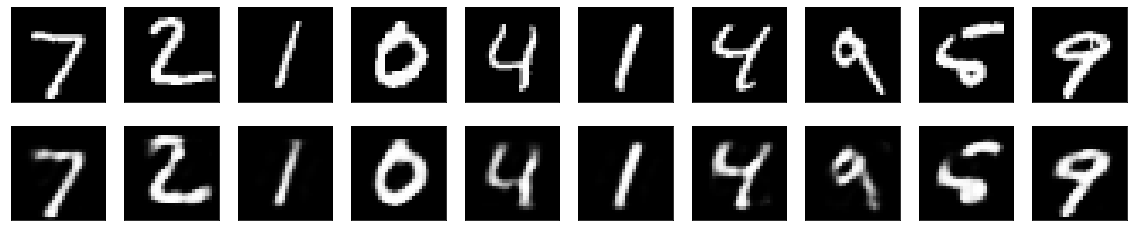

In [10]:
import matplotlib.pyplot as plt


n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(roundtrip_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

What about the compression? Let's check the sizes of the arrays.

In [11]:
encoded_imgs = autoencoder.transform(x_test)
print(f"x_test.shape[1]: {x_test.shape[1]}")
print(f"encoded_imgs.shape[1]: {encoded_imgs.shape[1]}")
cr = round((encoded_imgs.nbytes/x_test.nbytes), 2)
print(f"Compression ratio: 1/{1/cr:.0f}")

x_test.shape[1]: 784
encoded_imgs.shape[1]: 32
Compression ratio: 1/25
